In [1]:
!pip install tensorflow matplotlib pandas

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    Preserves aspect ratio of original image.
    Does not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image for AI model detection.
    desired_size : (width, height)
        Size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting for the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions. Pad the resulting image
    with solid black color pixels to fill the desired size.
    Do not modify the original image.
    :Parameters:
    ----------
    image : PIL.Image
        Input Image sized to fit an input tensor but without padding.
        Its possible that one size fits one tensor dimension exactly
        but the other size is smaller than
        the input tensor other dimension.
    desired_size : (width, height)
        Exact size expected by the AI model.
    :Returns:
    -------
    PIL.Image
        Resized image fitting exactly the AI model input tensor.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

In [4]:
def draw_kps(kps, template_image):

    pil_im = template_image
    draw = ImageDraw.Draw(pil_im)
    
    leftShoulder = False
    rightShoulder = False
    
    scoreList = {'LShoulder_score':0,'RShoulder_score':0,'LHip_score':0,'RHip_score':0}
    
    for i in range(kps.shape[0]):
        if kps[i, 2]:
                                
            x, y, r = int(round(kps[i, 1])), int(round(kps[i, 0])), 1
            
            if i == 5:
                leftShoulder = True
                leftShoulder_point = [x, y]
                scoreList['LShoulder_score'] = kps[i,-1]
                # print("leftShoulder_point : ", leftShoulder_point)
                
            if i == 6:
                rightShoulder = True
                rightShoulder_point = [x, y]
                scoreList['RShoulder_score'] = kps[i,-1]
                # print("rightShoulder_point : ", rightShoulder_point)
            
            leftUpPoint = (x-r, y-r)
            rightDownPoint = (x+r, y+r)
            twoPointList = [leftUpPoint, rightDownPoint]
            draw.ellipse(twoPointList, fill=(0, 255, 0, 255))
            
            if i == 11 and leftShoulder:
                leftHip_point = [x, y]
                # print("leftHip_point : ", leftHip_point)
                scoreList['LHip_score'] = kps[i,-1]
                draw.line((leftShoulder_point[0],leftShoulder_point[1], leftHip_point[0],leftHip_point[1]), fill='green', width=3)
            
            if i == 12 and rightShoulder:
                rightHip_point = [x, y]
                # print("rightHip_point : ", rightHip_point)
                scoreList['RHip_score'] = kps[i,-1]
                draw.line((rightShoulder_point[0],rightShoulder_point[1], rightHip_point[0],rightHip_point[1]), fill='green', width=3)
                
    return pil_im, scoreList

# PoseNet

In [5]:
posenet_model_path = "ai_models/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
posenet_interpreter = tf.lite.Interpreter(model_path= posenet_model_path)
posenet_interpreter.allocate_tensors()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
# for posenet

def parse_output(heatmap_data,offset_data, threshold):

    '''
    Input:
      heatmap_data - hetmaps for an image. Three dimension array
      offset_data - offset vectors for an image. Three dimension array
      threshold - probability threshold for the keypoints. Scalar value
    Output:
      array with coordinates of the keypoints and flags for those that have
      low probability
    '''

    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,4), np.float32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)
        pose_kps[i,3] = sigmoid(max_prob)
        #print(".... ", max_prob, threshold)
        if max_prob > threshold:
          if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
            pose_kps[i,2] = 1

    return pose_kps

In [8]:
def posenet_model_detection(template_image_src,interpreter=posenet_interpreter):
   
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    template_image = resize(image=_thumbnail, desired_size=(width, height))

    template_input = np.expand_dims(template_image.copy(), axis=0)
    template_input = (np.float32(template_input) - 127.5) / 127.5

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], template_input)

    # Invoke inference.
    interpreter.invoke()

    template_output_data = interpreter.get_tensor(output_details[0]['index'])
    template_offset_data = interpreter.get_tensor(output_details[1]['index'])

    template_heatmaps = np.squeeze(template_output_data)
    template_offsets = np.squeeze(template_offset_data)

    keypoints = parse_output(template_heatmaps, template_offsets, 0.3)

    output_img, scoreList = draw_kps(keypoints, template_image)
        
    return output_img, scoreList

# MoveNet

In [9]:
movenet_model_path =  "ai_models/lite-model_movenet_singlepose_thunder_3.tflite"
movenet_interpreter = tf.lite.Interpreter(model_path= movenet_model_path)
movenet_interpreter.allocate_tensors()

In [10]:
# for movenet
def get_keypoints(keypoints_with_scores, height, width, keypoint_threshold=0.11):
  
    keypoints_all = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    
    for idx in range(num_instances):
        
        kpts_y = keypoints_with_scores[0, idx, :, 1]
        kpts_x = keypoints_with_scores[0, idx, :, 0]
        
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        
        kpts_absolute_xy = np.stack([width * np.array(kpts_x), height * np.array(kpts_y), kpts_scores], axis=-1)
        keypoints_all.append(kpts_absolute_xy)
        
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))


    return keypoints_xy

In [11]:
def movenet_model_detection(template_image_src,interpreter=movenet_interpreter):
  
   
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height)) # input image
    template_image = resize(image=_thumbnail, desired_size=(width, height))

    template_input = np.expand_dims(template_image.copy(), axis=0)
    template_input = template_input.astype(np.float32)

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], template_input)

    # Invoke inference.
    interpreter.invoke()

    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    keypoints = get_keypoints(keypoints_with_scores, height, width)

    output_img, scoreList = draw_kps(keypoints, template_image)  # output image

    return output_img, scoreList

# Posenet Vs Movenet

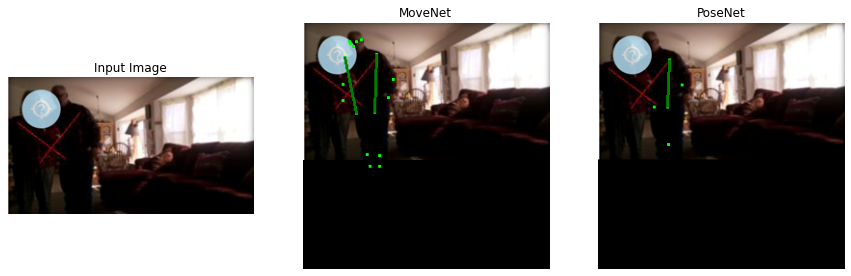


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.729215          0.58562    0.488324    0.618876
posenet         0.693424          0.00000    0.746721    0.000000



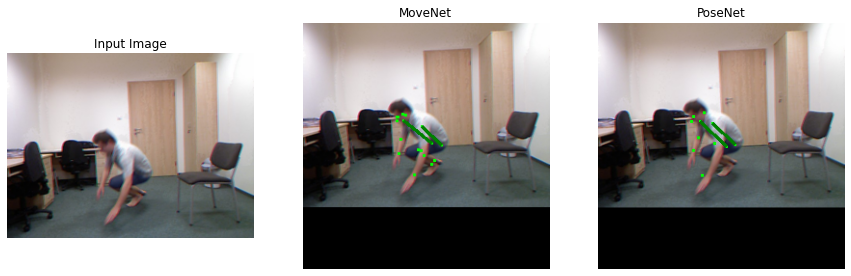


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.551456         0.685538    0.571250    0.497153
posenet         0.985805         0.813443    0.893849    0.958554



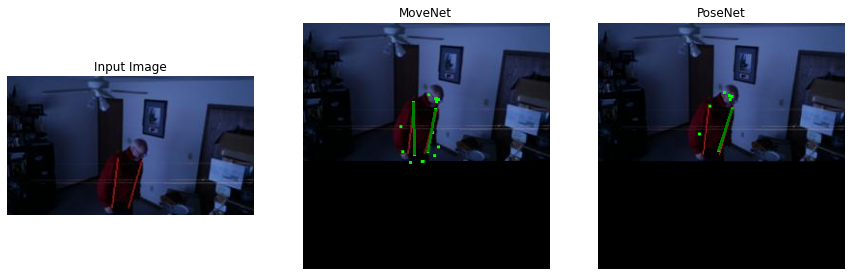


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.534104         0.484985    0.676260    0.518292
posenet         0.807302         0.788534    0.605821    0.000000



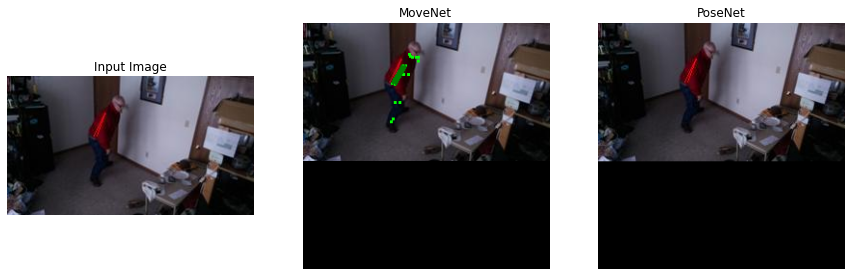


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.296005         0.294305    0.390929    0.445134
posenet         0.000000         0.000000    0.000000    0.000000



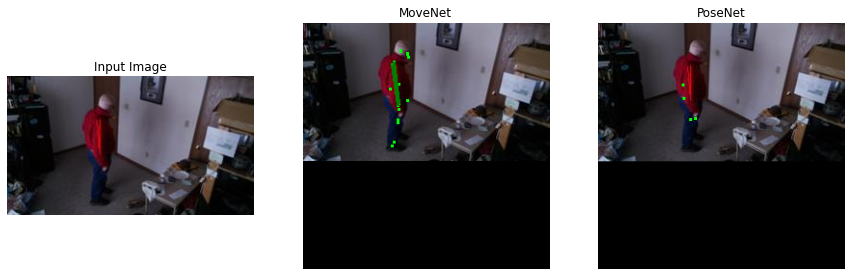


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.300482         0.440975    0.531954    0.600917
posenet         0.000000         0.000000    0.000000    0.000000



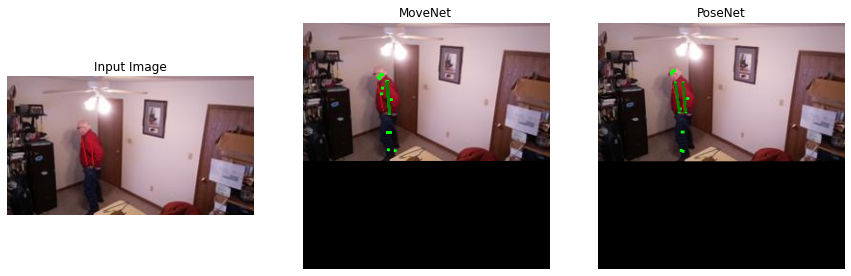


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.371929         0.437954    0.428109    0.401791
posenet         0.992133         0.859288    0.985552    0.945382



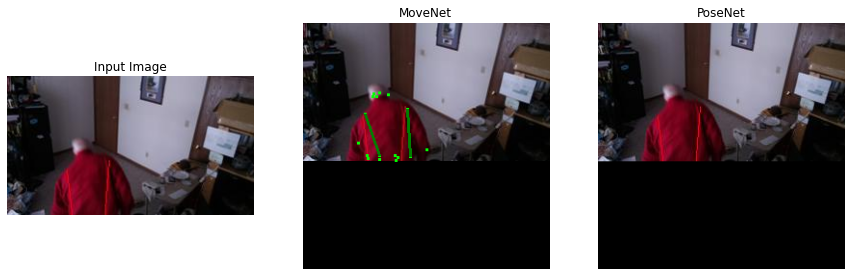


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.549722         0.628526    0.165886    0.122087
posenet         0.000000         0.000000    0.000000    0.000000



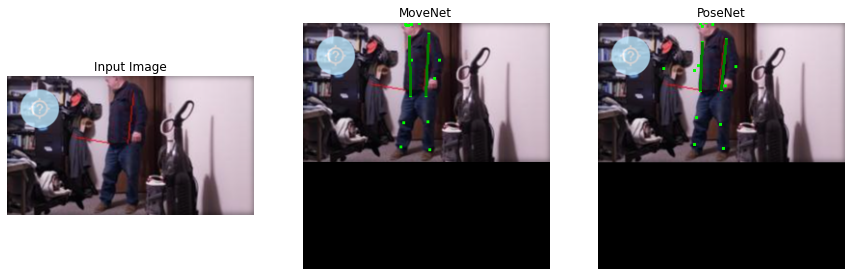


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.682065         0.539875    0.686491    0.758981
posenet         0.992887         0.824934    0.997804    0.968903



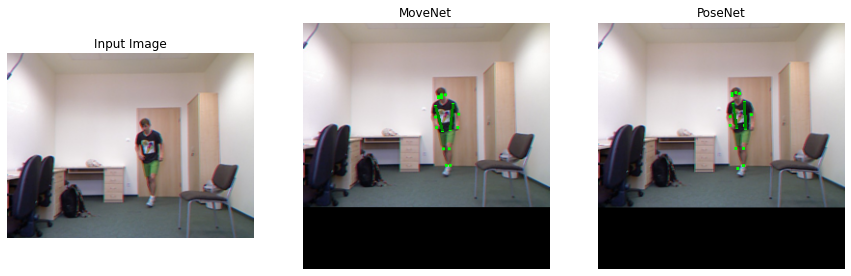


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.574028         0.661798    0.480063    0.483903
posenet         0.962872         0.947483    0.919050    0.753558



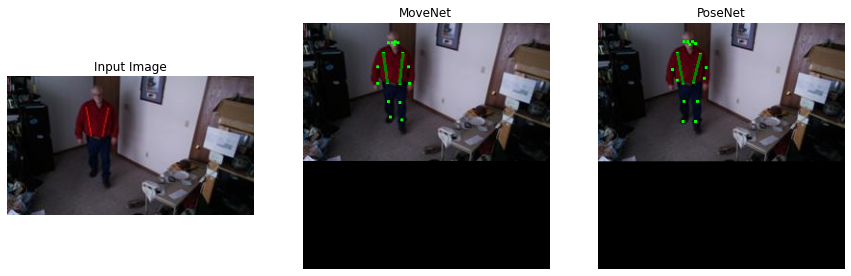


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.395344         0.302317    0.626515    0.549137
posenet         0.994389         0.982413    0.995445    0.992760



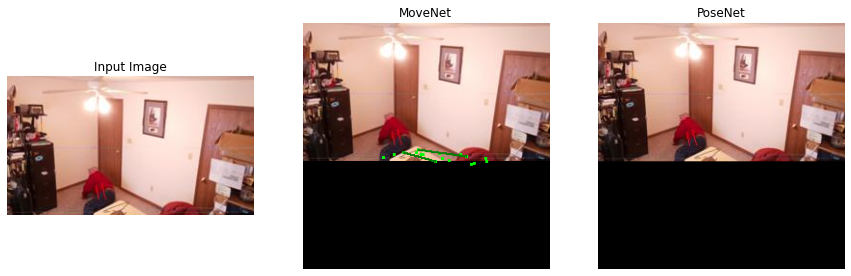


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet          0.14801         0.108777     0.26685    0.369541
posenet          0.00000         0.000000     0.00000    0.000000



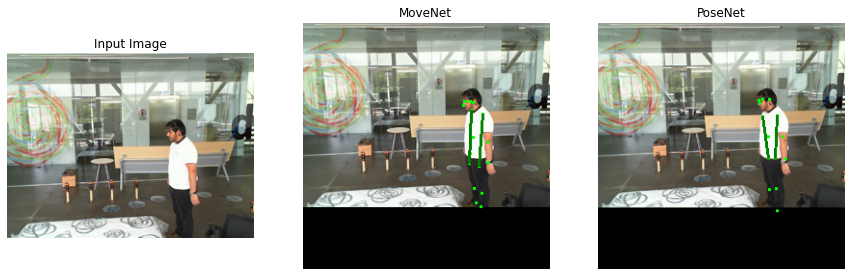


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.576428         0.593523    0.652052    0.692571
posenet         0.999402         0.981805    0.951065    0.842651



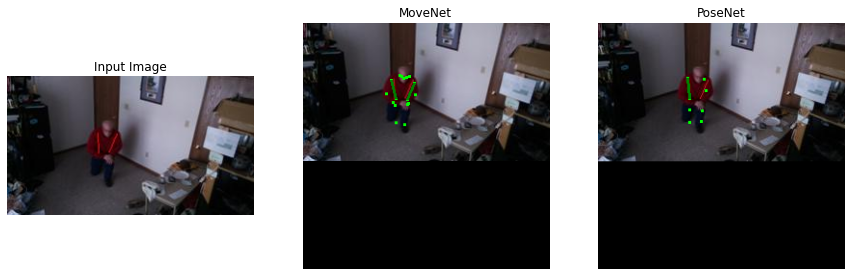


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.466756         0.488052    0.390538    0.350425
posenet         0.668459         0.706229    0.000000    0.610807



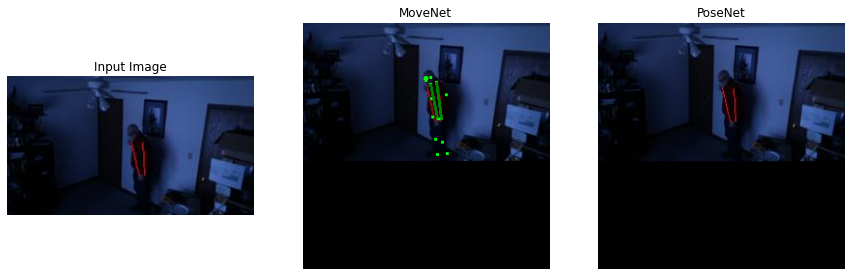


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.428684         0.352006    0.398671    0.491471
posenet         0.000000         0.000000    0.000000    0.000000



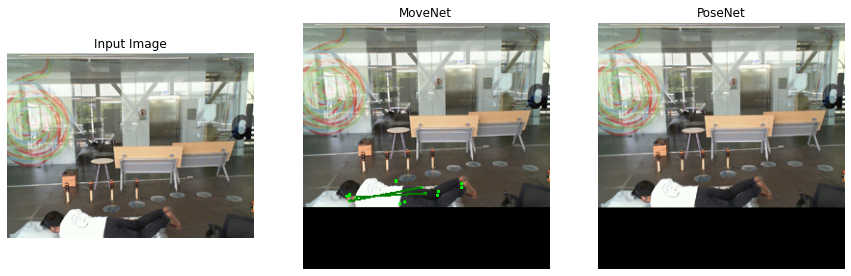


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.272308         0.308843     0.19749    0.171467
posenet         0.000000         0.000000     0.00000    0.000000



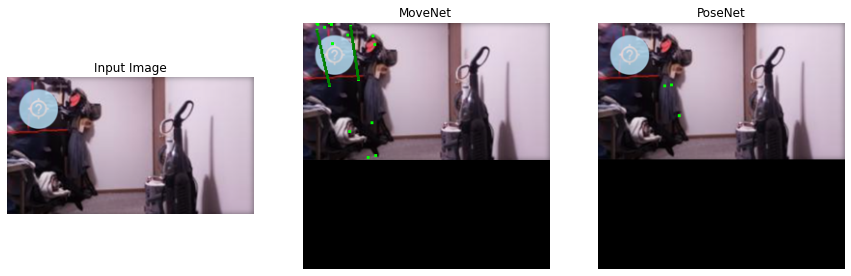


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.108230         0.058733    0.144446    0.038424
posenet         0.640908         0.661787    0.000000    0.000000



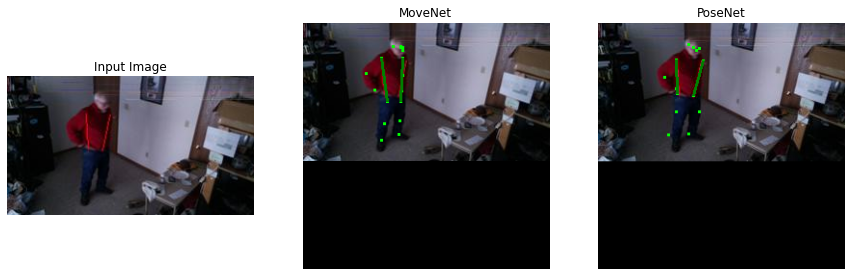


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.470449         0.566035    0.816051    0.694461
posenet         0.677153         0.916561    0.950210    0.812326



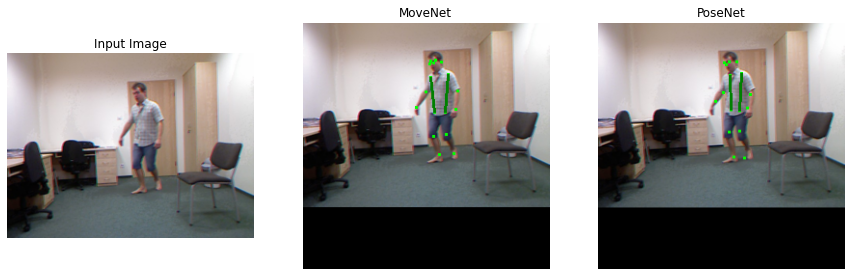


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.722023         0.518078    0.559008    0.590755
posenet         0.992990         0.997172    0.994260    0.996278



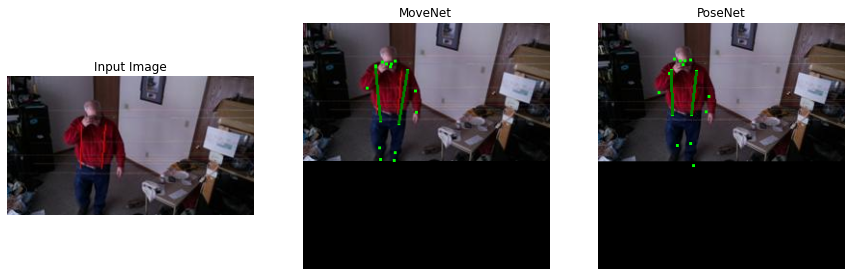


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.474797         0.667925    0.524839    0.667861
posenet         0.989706         0.886003    0.999304    0.945923



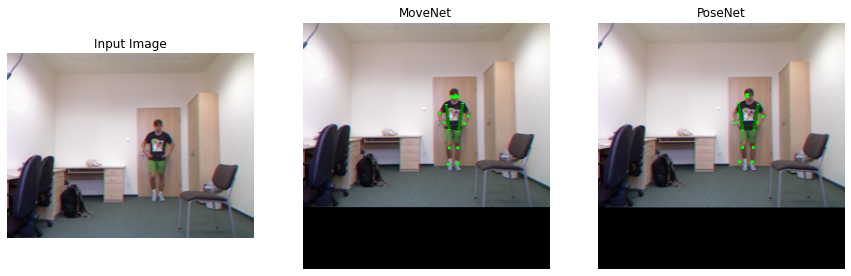


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.649309         0.577869    0.570143    0.533052
posenet         0.982027         0.934392    0.943476    0.927006



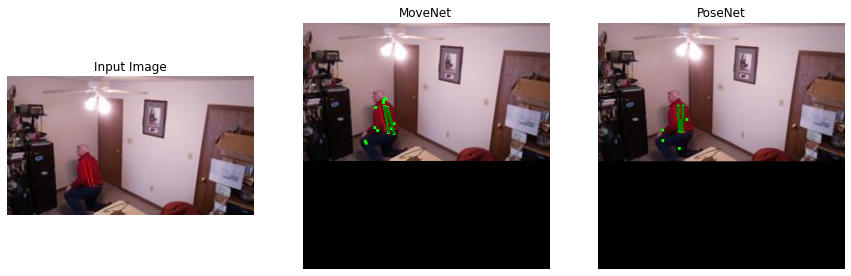


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.292363         0.252954    0.226877    0.263637
posenet         0.776043         0.897912    0.786955    0.805087



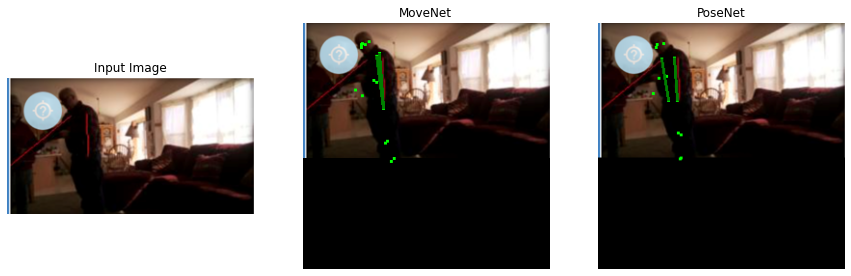


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.407789         0.524848    0.500353    0.652281
posenet         0.955995         0.962668    0.846824    0.864783



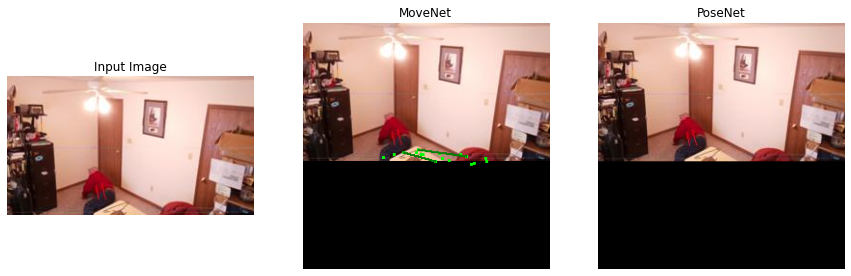


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet          0.14801         0.108777     0.26685    0.369541
posenet          0.00000         0.000000     0.00000    0.000000



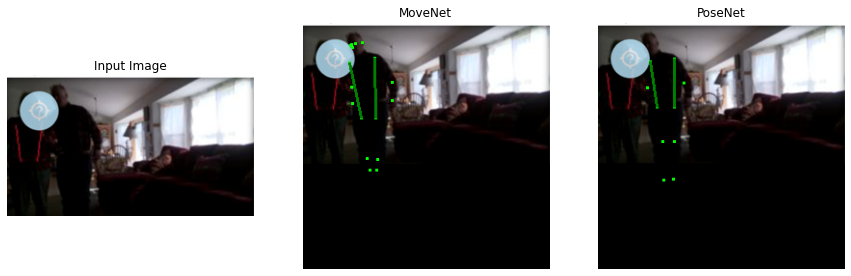


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.707875         0.623763    0.633353    0.644020
posenet         0.890897         0.707792    0.991340    0.855217



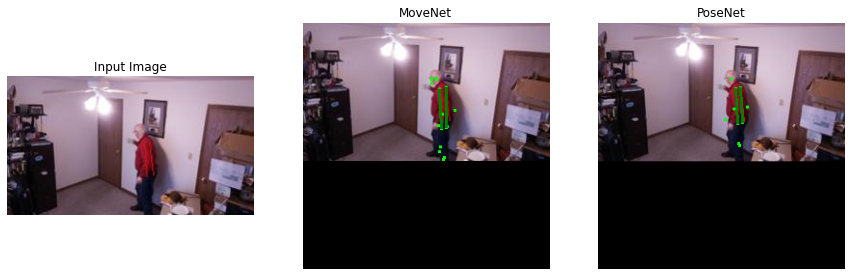


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.757575         0.502000    0.682892    0.575983
posenet         0.846683         0.942435    0.752360    0.861473



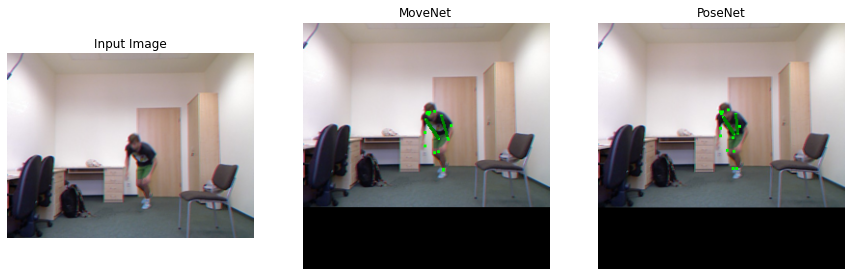


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.467571         0.432707    0.533694    0.443868
posenet         0.921941         0.989964    0.906372    0.907390



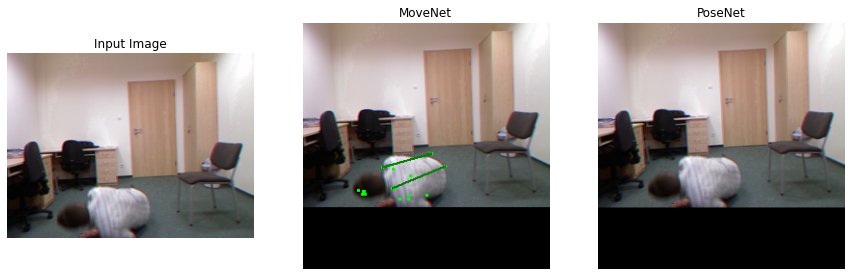


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.203491         0.159094    0.293808    0.355324
posenet         0.000000         0.000000    0.000000    0.000000



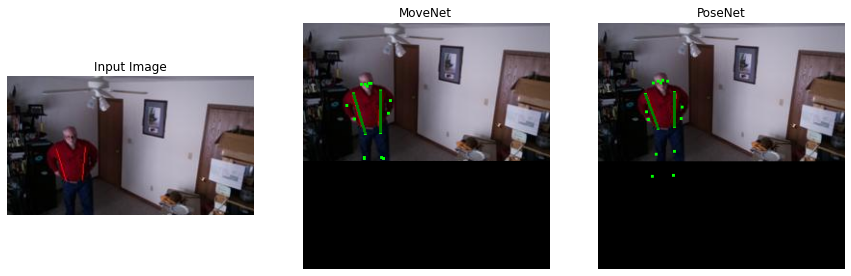


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.564597         0.628543    0.523149    0.563526
posenet         0.933490         0.950509    0.874614    0.977313



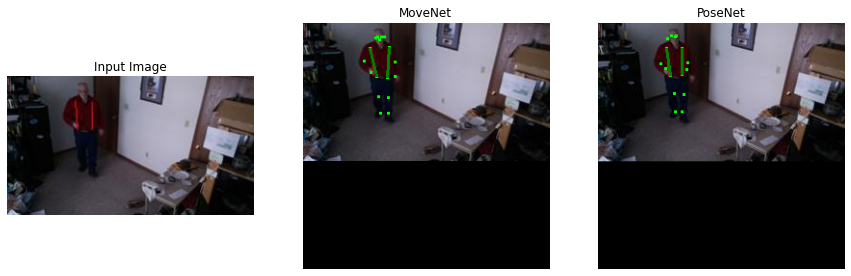


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.594564         0.697708    0.567156    0.577232
posenet         0.994971         0.998406    0.990839    0.987875



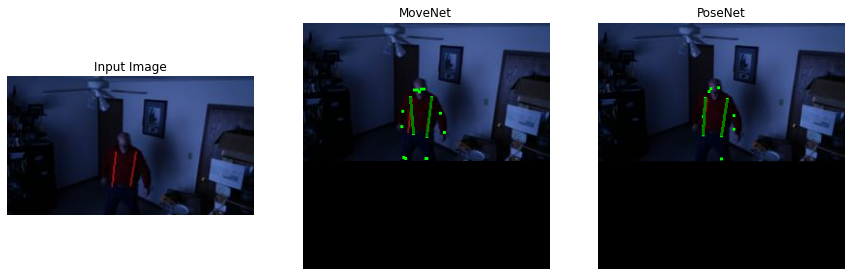


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.644606         0.593121    0.599704    0.612873
posenet         0.925541         0.764601    0.988810    0.844758



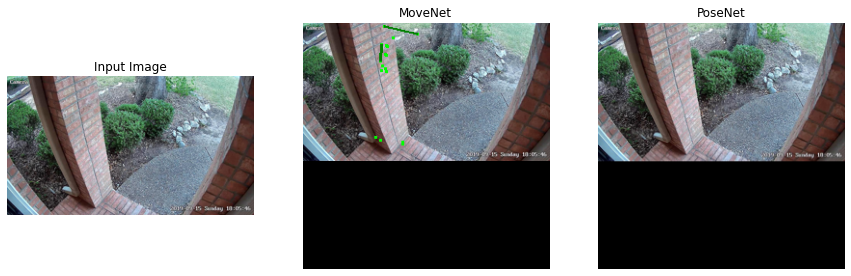


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.011779         0.019907    0.010419    0.027818
posenet         0.000000         0.000000    0.000000    0.000000



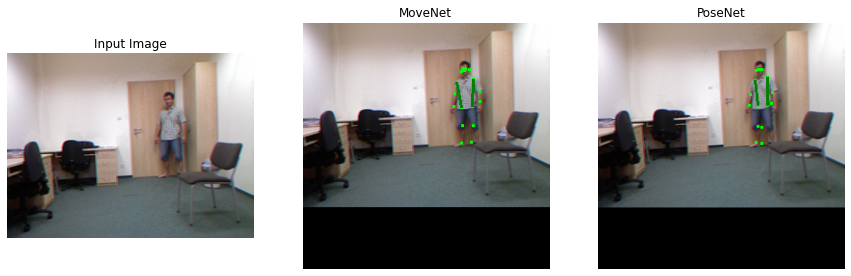


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.368592         0.407846    0.507245    0.531825
posenet         0.907152         0.994740    0.934951    0.994034



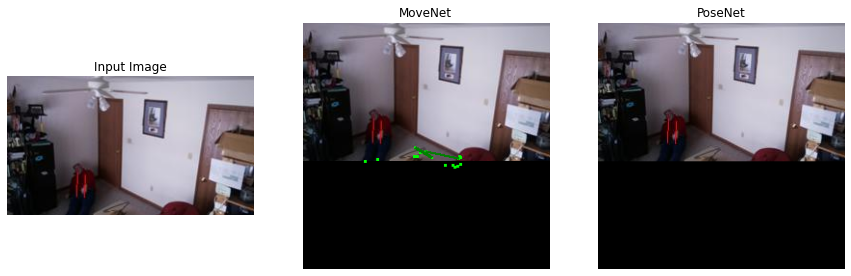


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.195157         0.169063    0.118221    0.071516
posenet         0.000000         0.000000    0.000000    0.000000



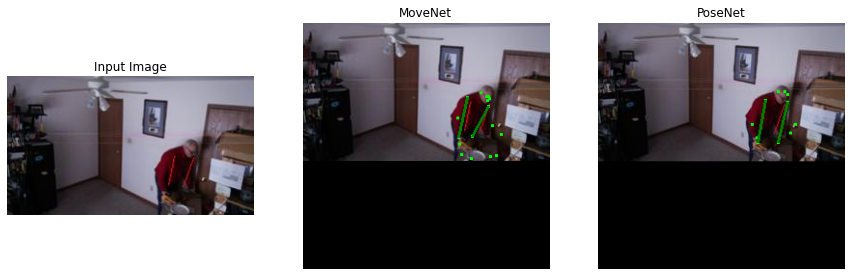


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet          0.45824         0.367250    0.671431    0.632985
posenet          0.92703         0.871254    0.937400    0.949941



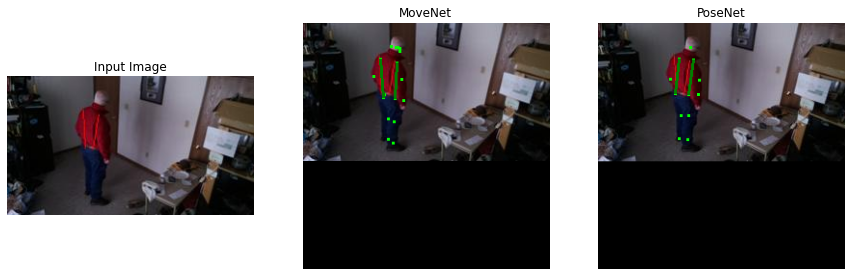


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.485261         0.580307    0.438394    0.494610
posenet         0.781118         0.951843    0.925763    0.992454



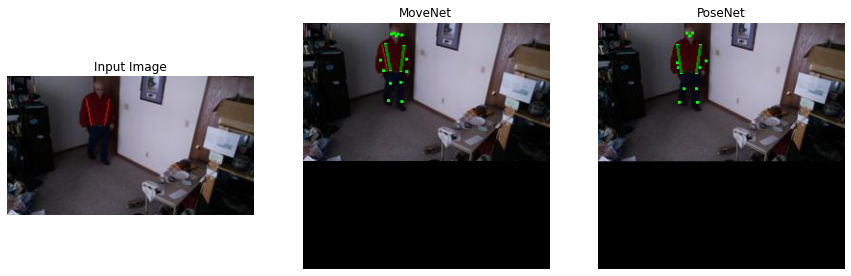


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.498564         0.664178    0.649357    0.635549
posenet         0.964768         0.953019    0.989592    0.974789



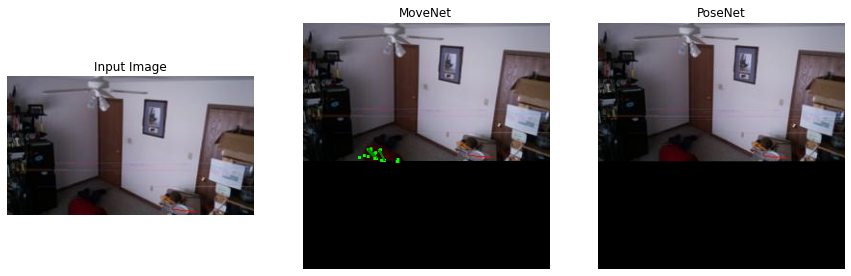


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.267743         0.202702    0.148062    0.123099
posenet         0.000000         0.000000    0.000000    0.000000



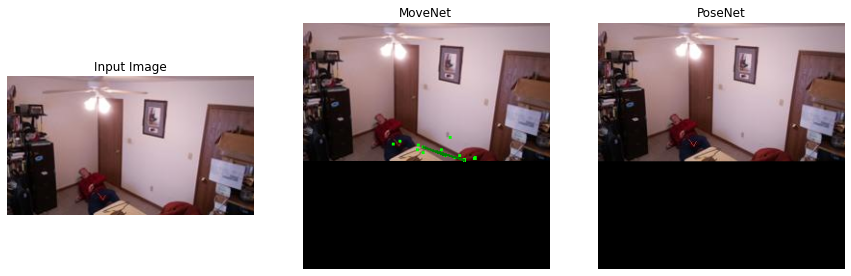


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.118486         0.066802    0.094939    0.152283
posenet         0.000000         0.000000    0.000000    0.000000



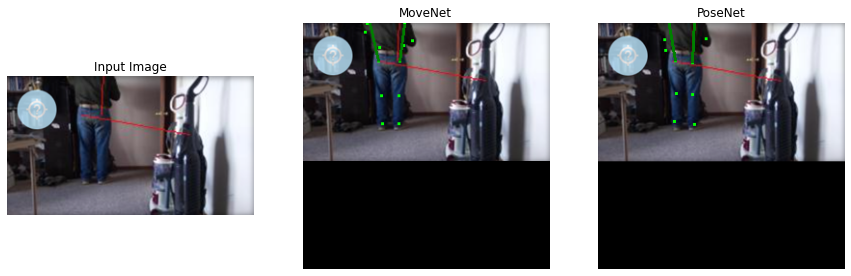


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.168734         0.167558    0.614498    0.572880
posenet         0.645109         0.945679    0.892022    0.992411



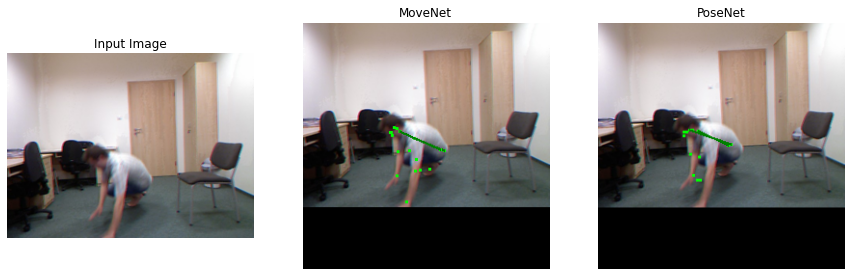


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.628801         0.674815    0.619655    0.794412
posenet         0.969418         0.941452    0.838154    0.769364



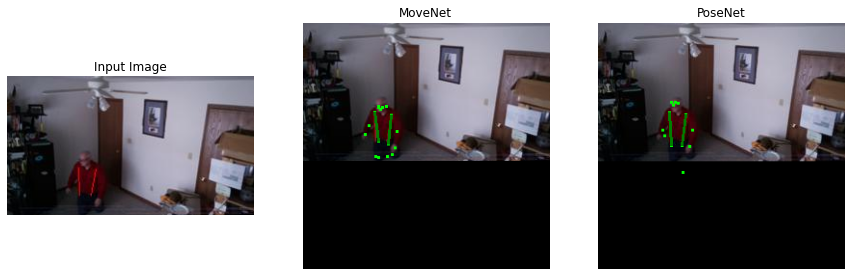


         LShoulder_score  RShoulder_score  LHip_score  RHip_score
movenet         0.399462         0.601171    0.338194    0.279555
posenet         0.992210         0.969022    0.975937    0.909321



In [12]:
import os
DATADIR = 'Images'
comparison_df = pd.DataFrame()

for template_path in os.listdir(DATADIR):
  
    template_image_src = Image.open(os.path.join(DATADIR,template_path))    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(256, 256)) # input image
    movenet_output_image, movenet_scoreList = movenet_model_detection(template_image_src.copy())
    posenet_output_image, posenet_scoreList = posenet_model_detection(template_image_src.copy())
    
    scoreList_table = pd.DataFrame(data = [movenet_scoreList, posenet_scoreList],
                                   columns = ['LShoulder_score','RShoulder_score','LHip_score','RHip_score'], 
                                   index=['movenet','posenet'])
    
    fig = plt.figure(figsize=(15,9))
    fig.add_subplot(1, 3, 1)
    plt.imshow(_thumbnail)    
    plt.axis("off")
    plt.title("Input Image")

    fig.add_subplot(1, 3, 2)
    plt.imshow(movenet_output_image)    
    plt.axis("off")
    plt.title("MoveNet")        

    fig.add_subplot(1, 3, 3)
    plt.imshow(posenet_output_image)    
    plt.axis("off")
    plt.title("PoseNet")        
    
    plt.show()
    
    
    print()
    print(scoreList_table)
    print()

    idx = scoreList_table.index.to_frame()
    idx.insert(0, 'image', template_path)
    idx.insert(1, 'model', ['movenet','posenet'])
    scoreList_table = scoreList_table.set_index(pd.MultiIndex.from_frame(idx),drop=True).droplevel(2)
    comparison_df = comparison_df.append(scoreList_table)

In [13]:
comparison_df

LShoulder_score  RShoulder_score  LHip_score  \
image           model                                                   
fall_img_46.png movenet         0.729215         0.585620    0.488324   
                posenet         0.693424         0.000000    0.746721   
fall_img_2.png  movenet         0.551456         0.685538    0.571250   
                posenet         0.985805         0.813443    0.893849   
fall_img_31.jpg movenet         0.534104         0.484985    0.676260   
                posenet         0.807302         0.788534    0.605821   
fall_img_45.jpg movenet         0.296005         0.294305    0.390929   
                posenet         0.000000         0.000000    0.000000   
fall_img_43.jpg movenet         0.300482         0.440975    0.531954   
                posenet         0.000000         0.000000    0.000000   
fall_img_27.jpg movenet         0.371929         0.437954    0.428109   
                posenet         0.992133         0.859288    0.985552   
fall_img_36.jpg movenet         0.549722         0.628526    0.165886   
                posenet         0.000000         0.000000    0.000000   
fall_img_18.png movenet         0.682065         0.539875    0.686491   
                posenet         0.992887         0.824934    0.997804   
fall_img_6.png  movenet         0.574028         0.661798    0.480063   
                posenet         0.962872         0.947483    0.919050   
fall_img_38.jpg movenet         0.395344         0.302317    0.626515   
                posenet         0.994389         0.982413    0.995445   
fall_img_22.jpg movenet         0.148010         0.108777    0.266850   
                posenet         0.000000         0.000000    0.000000   
fall_img_8.png  movenet         0.576428         0.593523    0.652052   
                posenet         0.999402         0.981805    0.951065   
fall_img_41.jpg movenet         0.466756         0.488052    0.390538   
                posenet         0.668459         0.706229    0.000000   
fall_img_29.jpg movenet         0.428684         0.352006    0.398671   
                posenet         0.000000         0.000000    0.000000   
fall_img_9.png  movenet         0.272308         0.308843    0.197490   
                posenet         0.000000         0.000000    0.000000   
fall_img_19.png movenet         0.108230         0.058733    0.144446   
                posenet         0.640908         0.661787    0.000000   
fall_img_42.jpg movenet         0.470449         0.566035    0.816051   
                posenet         0.677153         0.916561    0.950210   
fall_img_1.png  movenet         0.722023         0.518078    0.559008   
                posenet         0.992990         0.997172    0.994260   
fall_img_39.jpg movenet         0.474797         0.667925    0.524839   
                posenet         0.989706         0.886003    0.999304   
fall_img_5.png  movenet         0.649309         0.577869    0.570143   
                posenet         0.982027         0.934392    0.943476   
fall_img_26.jpg movenet         0.292363         0.252954    0.226877   
                posenet         0.776043         0.897912    0.786955   
fall_img_47.png movenet         0.407789         0.524848    0.500353   
                posenet         0.955995         0.962668    0.846824   
fall_img_23.jpg movenet         0.148010         0.108777    0.266850   
                posenet         0.000000         0.000000    0.000000   
fall_img_48.png movenet         0.707875         0.623763    0.633353   
                posenet         0.890897         0.707792    0.991340   
fall_img_28.jpg movenet         0.757575         0.502000    0.682892   
                posenet         0.846683         0.942435    0.752360   
fall_img_7.png  movenet         0.467571         0.432707    0.533694   
                posenet         0.921941         0.989964    0.906372   
fall_img_4.png  movenet         0.203491         0.159094    0.293808   
          